In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
appeals_df = pd.read_csv('../data/zoning_board_appeals_tracker.csv')
voterdata_df = pd.read_csv('../data/VM2Uniform--MA--2021-01-19.tab', sep='\t', encoding='iso-8859-1', usecols=['Residence_Addresses_Zip', 'CommercialData_EstimatedHHIncomeAmount'])

zip_income_data = zip(voterdata_df['Residence_Addresses_Zip'], voterdata_df['CommercialData_EstimatedHHIncomeAmount'])

zip_to_mean_income = dict.fromkeys(voterdata_df['Residence_Addresses_Zip'], None)

for zipcode, income in zip_income_data:
    try:
        if zip_to_mean_income[zipcode] is None:
            zip_to_mean_income[zipcode] = []
        if type(income) == str:
            income = int(income[1:])
            zip_to_mean_income[zipcode].append(income)
    except:
        pass

for zipcode in zip_to_mean_income.keys():
    if zip_to_mean_income[zipcode] is not None:
        zip_to_mean_income[zipcode] = np.mean(zip_to_mean_income[zipcode])

/home/timevdo/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/timevdo/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [53]:
print(appeals_df.columns.to_list())
appeals_df.head()


['address', 'status', 'parent_apno', 'boa_apno', 'appeal_type', 'contact', 'submitted_date', 'received_date', 'hearing_date', 'ever_deferred', 'num_deferrals', 'final_decision_date', 'decision', 'closed_date', 'city', 'zip', 'ward', 'zoning_district', 'project_description']


,address,status,parent_apno,boa_apno,appeal_type,contact,submitted_date,received_date,hearing_date,ever_deferred,num_deferrals,final_decision_date,decision,closed_date,city,zip,ward,zoning_district,project_description
0,14 Victoria ST Dorchester 02125,Community Process,U491529793,BOA1534425,Zoning,Matt Jeske,2023-10-10,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,Dorchester,2125,13,Dorchester Neighborhood,We would to add 2 vehicle driveway on left sid...
1,122 Seaver ST Dorchester 02121,Community Process,U491485629,BOA1534528,Zoning,Erika Guerrero,2023-10-10,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,Dorchester,2121,12,Roxbury Neighborhood,Use or premises Food trailer in parking space ...
2,9 Mckay Pl East Boston 02128,Community Process,ERT1523974,BOA1534462,Zoning,derric small,2023-10-10,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,East Boston,2128,1,East Boston Neighborhood,Demolish existing structures combine lots erec...
3,3927 Washington ST Roslindale 02131,Community Process,ALT1522878,BOA1534015,Zoning,Anthony Ross,2023-10-07,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,Roslindale,2131,19,Jamaica Plain Neighborhood,Add 4th floor to existing 3 story unit buildin...
4,27 Hopkins Rd Jamaica Plain 02130,Community Process,ERT1432001,BOA1534017,Zoning,Anthony Ross,2023-10-07,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,Jamaica Plain,2130,19,Jamaica Plain Neighborhood,Erect single family home with attached two car...


In [60]:
# Add model features
"""
We want
    appeal_type, status -- need to do indexing
    zip, ward, ever_deferred, num_deferrals -- include
    also include income of zip
"""

model_data = pd.DataFrame()

model_data[['zip', 'ward', 'ever_deferred', 'num_deferrals']] = appeals_df[['zip', 'ward', 'ever_deferred', 'num_deferrals']]
model_data['ever_deferred'] = model_data['ever_deferred'].fillna('N')
model_data['ever_deferred'] = model_data['ever_deferred'].replace('N', 0).replace('Y', 1)
model_data['num_deferrals'] = model_data['num_deferrals'].fillna(0)

appeal_list = list(set(appeals_df['appeal_type']))
status_list = list(set(appeals_df['status']))
model_data['appeal_type'] = appeals_df['appeal_type'].apply(lambda a : appeal_list.index(a))

model_data['status'] = appeals_df['status'].apply(lambda s : status_list.index(s))
model_data['year'] = pd.to_datetime(appeals_df['submitted_date']).dt.year
model_data['month'] = pd.to_datetime(appeals_df['submitted_date']).dt.month
model_data['income'] = appeals_df['zip'].apply(lambda z : zip_to_mean_income[z])

#model_data['day'] = pd.to_datetime(appeals_df['submitted_date']).dt.day
model_data['denied'] = appeals_df['decision'].apply(lambda d : 1 if d == 'DeniedPrej' or d == 'Denied' else 0)

print(len(model_data[model_data['denied'] == 1]), len(model_data[model_data['denied'] == 0]))

model_data.head()

1101 7942


,zip,ward,ever_deferred,num_deferrals,appeal_type,status,year,month,income,denied
0,2125,13,0,0.0,0,3,2023,10,85337.156606,0
1,2121,12,0,0.0,0,3,2023,10,53875.984289,0
2,2128,1,0,0.0,0,3,2023,10,77779.589967,0
3,2131,19,0,0.0,0,3,2023,10,102257.050240,0
4,2130,19,0,0.0,0,3,2023,10,120167.693612,0


Accuracy on testing set =  0.8628925254312251
RMSE on testing set =  0.13710747456877487


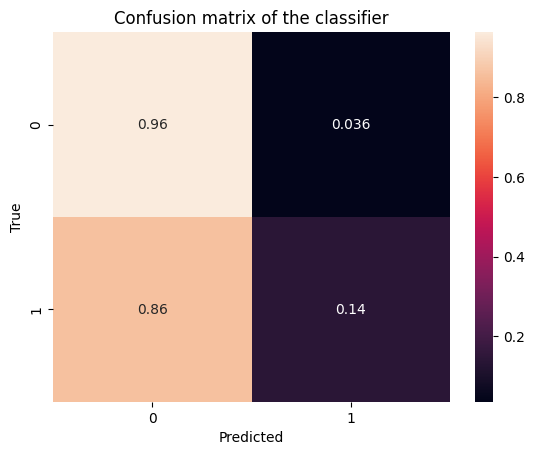

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import seaborn as sns

X_train, X_test, Y_train, Y_test = train_test_split(
        model_data.drop(['denied'], axis=1),
        model_data['denied'],
        test_size=1/4.0,
        random_state=0
    )

knn_model = BaggingClassifier(
    KNeighborsClassifier(n_neighbors=50, weights='distance'),
    n_estimators=50
).fit(X_train, Y_train)

Y_test_predictions = knn_model.predict(X_test)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions))

cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy on testing set =  0.6696914700544465
RMSE on testing set =  0.33030852994555354


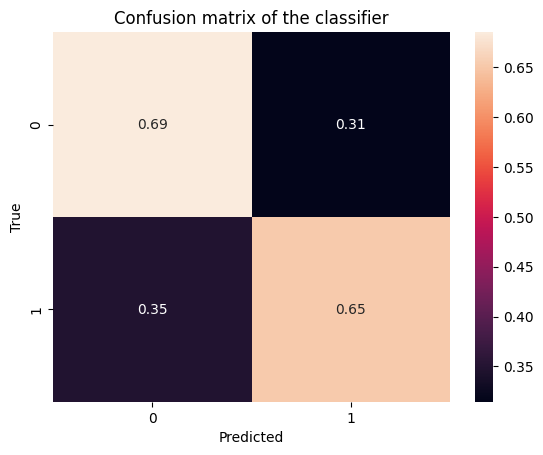

In [61]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.preprocessing as prs

#undersample to address skew
S = 1
model_data = model_data.drop(
    model_data[model_data['denied'] == 0].sample(
        int(np.round(S * (len(model_data[model_data['denied'] == 0]) - len(model_data[model_data['denied'] == 1]))))
    ).index
)

X_train, X_test, Y_train, Y_test = train_test_split(
        model_data.drop(['denied'], axis=1),
        model_data['denied'],
        test_size=1/4.0,
        random_state=0
    )

X_train_cpy = X_train.copy()

tree_model = RandomForestClassifier(max_features=None, n_estimators=1000).fit(X_train, Y_train)

Y_test_predictions = tree_model.predict(X_test)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions))

cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

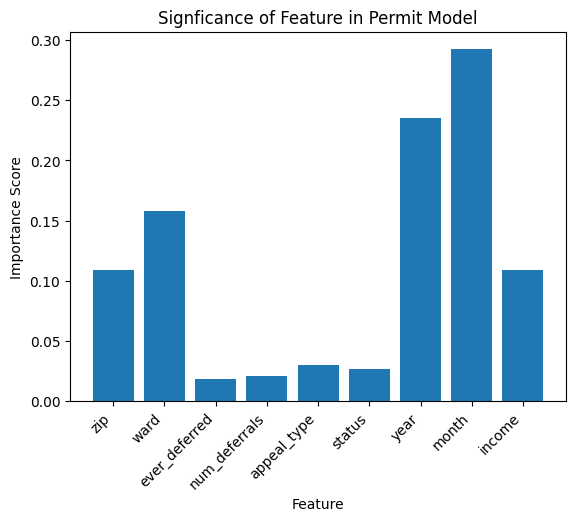

In [63]:
labels = list(X_train_cpy.columns)
vals = tree_model.feature_importances_

assert len(labels) == len(vals)

plt.bar(labels, vals)
plt.title("Signficance of Feature in Permit Model")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.show()